In [1]:
import pandas as pd
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer 
import re
import gensim
import numpy as np


def pre_proc(ab):
    ab = re.sub("[\(\[].*?[\)\]]", "", ab) # removes square parentheses and text inside [generally in other languages]
    token1 =  nltk.word_tokenize(ab) # tokenization
    token1 = [re.sub(r'\W+', ' ', t.lower()) for t in token1]  # removes punctuation
    return list(filter(lambda x:len(x)>2,token1)) # # removes words shorter than 2 chars

lmtzr = WordNetLemmatizer()
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
with open("article_stopwords_stem.txt","r") as f:
    article_stopwords = str()
    for i,line in enumerate(f):
        article_stopwords += line
    article_stopwords = eval(article_stopwords)
print("Article stopwords: {}".format(len(article_stopwords)))

stem = PorterStemmer()
morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}

def proc(token1,n_words=200):
    token1 = nltk.pos_tag(token1) # lemmatization step
    token1 = list( map(lambda x:lmtzr.lemmatize(x[0], pos=morphy_tag[x[1]]), filter(lambda x:x[1]=='NN' or x[1]=='JJ' or x[1]=='VB',token1)) )
    token1 = [w for w in token1 if w not in stop_words] # removes stopwords
    token1 = [stem.stem(w) for w in token1] # stemming
    token1 = ["child" if w=="children" else w  for w in token1] # corrects child
    token1 = bigram[token1] # seaches for bigrams
    token1 = [w for w in token1 if w not in article_stopwords] # removes stopwords
    return token1 


dataset = pd.read_excel("scopus_telepsych_filtered.xlsx",index_col=0)
if "GR" in dataset.columns:
    dataset= dataset[dataset.Valid==1][dataset.GR==1].drop(columns=["Valid","GR"]).reset_index(drop=True)
else:
    dataset = dataset[dataset.Valid==1].drop(columns=["Valid"]).reset_index() 

# prepare for tokenization 
dataset["tok"] = dataset["Title"].apply(lambda x:x + " " if type(x)==str else "") +dataset["Abstract"]
print("Number of Articles:",len(dataset))


dataset.tok = dataset.tok.apply(lambda x: pre_proc(x.lower()) if type(x) is str else x)
bigram = gensim.models.Phrases(dataset.tok[dataset.tok.isna()==False].values,min_count=2)
dataset["Author Keywords"] = dataset["Author Keywords"].apply(lambda x: x.lower().split("; ") if type(x)==str else x)
dataset["Index Keywords"] = dataset["Index Keywords"].apply(lambda x: x.lower().split("; ") if type(x)==str else x)

for i,tok in enumerate(dataset["tok"]):
    temp = list()
    ab = dataset["tok"][i]
    if type(ab)==list:
        temp.extend(ab)
    ak = dataset["Author Keywords"][i]
    if type(ak)==list:
        temp.extend(ak)
    ik = dataset["Index Keywords"][i]
    if type(ik)==list:
        temp.extend(ik)
    if temp:
        dataset["tok"][i]=temp
        
dataset["tok"].apply(lambda x: [w.strip() for w in x] if type(x)==list else x )
dataset.tok = dataset.tok.apply(lambda x: proc(x) if type(x) is list else x)
dataset["tok"] = dataset["tok"].apply(lambda x: [w.replace("_", " ") for w in x] if type(x)==list else x)
dataset["tok"] = dataset["tok"].apply(lambda x: [w.replace("-", " ") for w in x] if type(x)==list else x)
dataset["tok"].apply(lambda x: [w.strip() for w in x] if type(x)==list else x )

dataset_full = dataset.copy()
dataset = dataset[dataset.tok.isna()==False] # removes items without abstract
print("Number of Articles with Tokens:",len(dataset))


unable to import 'smart_open.gcs', disabling that module
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oldboy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Article stopwords: 115


C:\Users\oldboy\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Number of Articles: 441


C:\Users\oldboy\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of Articles with Tokens: 441


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=.8, max_features=200000,
                                 min_df=0.001, stop_words=None,
                                 use_idf=True, tokenizer=lambda x:x,lowercase=False)

tfidf_matrix = tfidf_vectorizer.fit_transform(dataset.tok.values) 


terms = tfidf_vectorizer.get_feature_names()
from sklearn.metrics.pairwise import cosine_similarity
dists = 1 - cosine_similarity(tfidf_matrix)

len(terms)

4963

In [3]:
from sklearn.manifold import TSNE
import plotly.express as px

def keywords(t,df=dataset):
    words = [w[0] for w in Counter([w for tok in df[df.topic==t].tok for w in tok]).most_common(100)]
    doc_t = df[df.topic==t].tok
    wpd = dict()
    for w in words:
        wpd[w]=0
        for d in doc_t:
            if w in d:
                wpd[w] += 1

    return sorted([(w,(wpd[w]/len(doc_t))*100) for w in  wpd],key=lambda x: x[1],reverse=True)

psy_pos = TSNE(n_components=2,random_state=50).fit_transform(dists)#tfidf_matrix.toarray())



<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
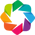

Clusters  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]


:Overlay
   .Scatter.Topic_Visualization.I  :Scatter   [x]   (y,topic,Title,t_name)
   .Scatter.Topic_Visualization.II :Scatter   [x]   (y,topic,Title,t_name)

In [4]:
import holoviews as hv
#!pip install colorcet
from holoviews import dim
hv.extension('bokeh')
import hdbscan
from collections import Counter

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(psy_pos)
psy_clusters = clusterer.labels_

dataset["x"] = psy_pos[:, 0]
dataset["y"] = psy_pos[:, 1]
dataset["topic"] = psy_clusters
print("Clusters ",sorted(dataset['topic'].unique()))
dataset['keywords']="None"
for c in sorted(dataset['topic'].unique()):
    temp =  keywords(c)
    dataset.loc[dataset['topic']==c,"keywords"] = ":".join([k[0] for k in temp][0:10] )
dataset['t_name'] = dataset['keywords'].apply(lambda x: '_'.join(x.split(":")[0:3]) )

#tps = dataset[["topic","t_name","EID"]].groupby("t_name").agg({"topic":pd.unique,"EID":"count"}).sort_values(by="EID",ascending=False).reset_index()
#tps = tps.loc[1:11,"topic"].to_list()

#dataset["topic"] = dataset["topic"].apply(lambda x: x if x in tps else -1)

unscatter = hv.Scatter(dataset[dataset["topic"]==-1],"x",["y","topic","Title","t_name"],label="Topic Visualization").opts(tools=["hover"],size=8,color="white",hover_fill_color="gray",line_color="black",toolbar=None,width=600,height=400,show_legend=False)
scatter = hv.Scatter(dataset[dataset["topic"]>-1],"x",["y","topic","Title","t_name"],label="Topic Visualization").opts(tools=["hover"],size=8,color="topic",hover_line_color="white",line_color="black",cmap="glasbey_light",toolbar=None,width=600,height=400,show_legend=False)

scatter = unscatter * scatter 


hv.save(scatter,"clu.html")
scatter

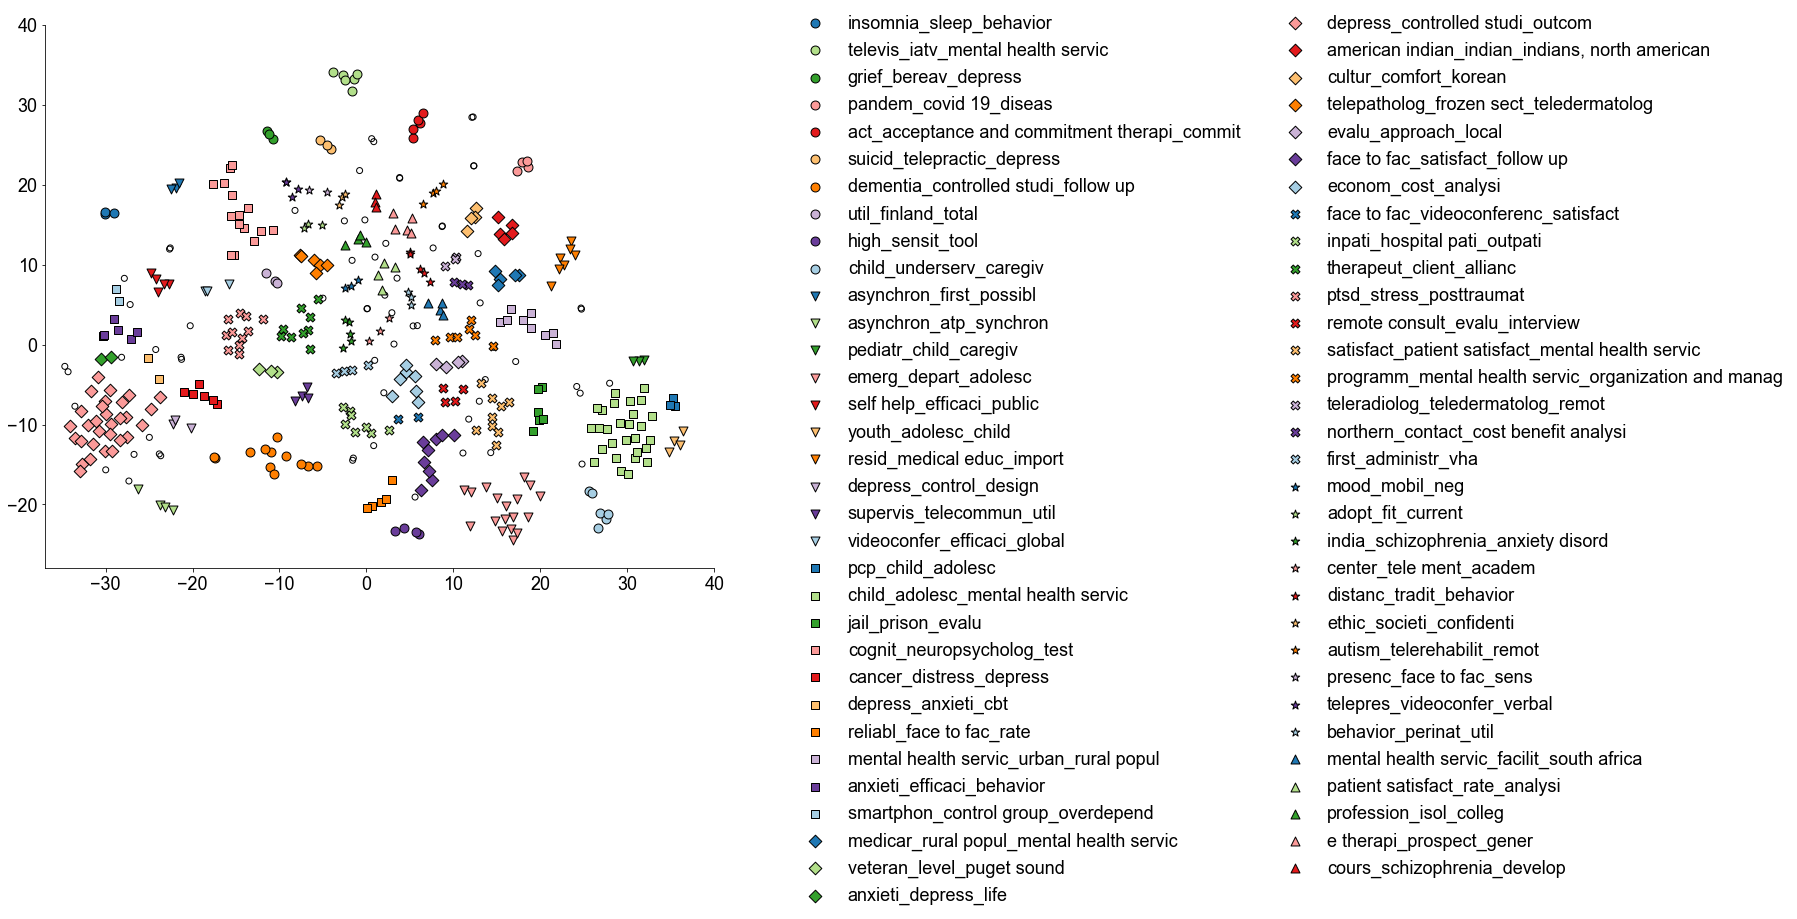

In [80]:

import matplotlib
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,10))

CB_color_cycle = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a']
marks = [ ".", "o", "v", "s", "D", "X", "*", "^", "<", ">" ] 

unc = dataset["topic"]==-1
plt.scatter(dataset["x"][unc],dataset["y"][unc],c="",edgecolors="black")

c=0
m=0
for clu in sorted(dataset['topic'].unique())[1:]:
    c += 1
    if clu%len(CB_color_cycle)==0:
        c += 0
        m += 1
    tpc = dataset["topic"]==clu
    plt.scatter(dataset["x"][tpc],dataset["y"][tpc],s=80,c=CB_color_cycle[c%len(CB_color_cycle)],marker=marks[m],edgecolors="black",label=dataset["t_name"][tpc].unique()[0])

ax1.spines['top'].set_visible(False)
#ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.tick_params(
#    axis='both',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    left=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False,
#    labelleft=False) # labels along the bottom edge are off

plt.legend(bbox_to_anchor=(1.1, 1.05), frameon=False,  ncol=2)
ax1.set_ylim((-28,40))
ax1.set_xlim((-37,40))
#plt.tight_layout()
plt.savefig("topic_scatter.tiff",dpi=300, bbox_inches = "tight")

C:\Users\oldboy\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


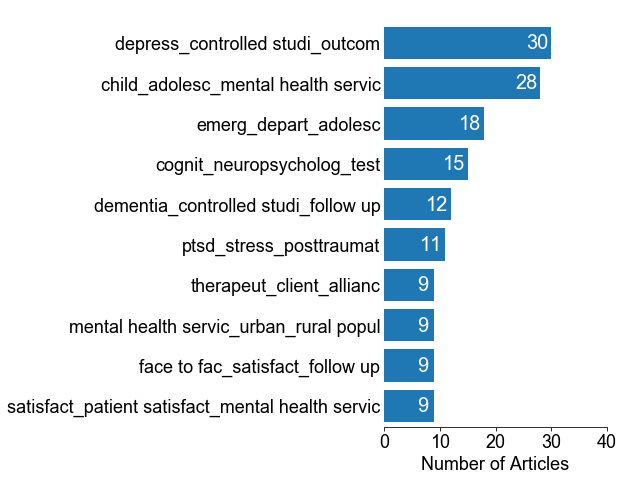

In [82]:
n_art = dataset['t_name'].value_counts()[1:11].sort_values(ascending=True)
#hv.Bars(n_art).opts(invert_axes=True,width=500,toolbar=None)

fig, ax1 = plt.subplots(figsize=(4,8))

ax1.barh(n_art.index,n_art.values)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_position(('outward', -15))

ax1.tick_params(axis=u'y', which=u'both',length=0)
ax1.set_xlim((0,40))
ax1.set_xlabel("Number of Articles")

for i,(ind,n) in enumerate(n_art.iteritems()):
    if n>=10:
        plt.text(x = n-4.5 , y = i-.15 , s = n , size = 20, color="white")
    else:
        plt.text(x = n-3 , y = i-.15 , s = n , size = 20, color="white")

fig.tight_layout()
fig.savefig("topic_hist.tiff",dpi=300, bbox_inches = "tight")

In [83]:
f = open("topic_content.md","w")
sunic = list(dataset['topic'].value_counts().index[1:])
sunic.append(-1)
for i,t in enumerate(sunic):
    if i==0:
        f.write("## INDEX \n")
        f.write( " ".join(["[topic {0:1.0f}](#TOPIC-{0:1.0f}-back)".format(t) if t>=0 else "[topic None](#TOPIC-none-back)"  for t in sunic] ) )
        f.write("\n")
    if t==-1:
        f.write("## TOPIC: None [back](#index)\n")
        #break
    else:
        f.write("## TOPIC: {:1.0f} [back](#index)\n".format(t))
    
    if t!=-1:
        kw=dataset[dataset['topic']==t]["keywords"].values[0].replace(":",";")
        f.write("### Keywords: {}\n".format(kw))

    doc_t=dataset[dataset['topic']==t]
    f.write("#### Number of Articles: {}\n".format(len(doc_t)))
    for i,doc in enumerate(doc_t["Title"].values):

        eid=doc_t["EID"].values[i]
        f.write("{} **{}**\n".format(str(i)+'.',doc.encode("ascii",'ignore').decode('utf-8')))
        ab = doc_t["Abstract"].values[i][:].replace("\r\n"," ").encode("ascii",'ignore').decode('utf-8')
        #for k in kw.split(":"):
        #    for match in re.finditer(k, ab.lower()):
        #        ab = ab[:match.start()]+"**"+ab[match.start():match.end()]+"**"+ab[match.end():]
        f.write("{} eid: {}\n".format(ab,eid))

        #if i==10:
        #    break
            
f.close()

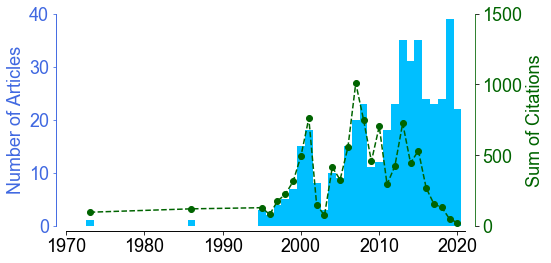

In [85]:
temp = dataset.groupby("Year").agg({"EID":"count",'Cited by':"sum"}).reset_index()
temp["Year"] = temp["Year"].apply(lambda x:int(x))

import matplotlib.pyplot as plt 
import matplotlib

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.set_ylabel('Number of Articles', color="royalblue")  # we already handled the x-label with ax1
ax1.bar(temp["Year"], temp["EID"], width=1, color="deepskyblue")
ax1.tick_params(axis='y', colors='royalblue')
ax1.spines['left'].set_color('royalblue')
ax1.spines['right'].set_color('royalblue')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.spines['left'].set_position(('outward', 10))
ax1.spines['bottom'].set_position(('outward', 5))
ax1.set_ylim((0,40))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Sum of Citations', color="darkgreen")  # we already handled the x-label with ax1
ax2.plot(temp["Year"], temp["Cited by"], color="darkgreen",marker="o",linestyle="dashed")
ax2.tick_params(axis='y', labelcolor="darkgreen")
ax2.spines['left'].set_color('royalblue')
ax2.spines['right'].set_color('darkgreen')
#ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_position(('outward', 10))
ax2.spines['right'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 5))
ax2.set_ylim((0,1500))
ax2.set_xlim((1970,2021))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig("arts_cits.tiff",dpi=300, bbox_inches = "tight")
plt.show()

In [86]:
years = dataset["Year"].sort_values().unique()

most_cited = pd.DataFrame(columns=dataset.columns)
for i,y in enumerate(years):
    most_cited.loc[len(most_cited)+1,:] = dataset[dataset["Year"]==y].sort_values(by="Cited by",ascending=False).reset_index(drop=True).head(1).values

most_cited = most_cited[['Year','Cited by','Title', 'Abstract','Authors','Source title','DOI']].sort_values(by="Year").reset_index(drop=True)



In [87]:
f = open("most_cited.md","w")

for i in range(0,len(most_cited)):
    
    f.write("## YEAR: {:1.0f} Citations: {:1.0f}\n".format(most_cited.loc[i,"Year"],most_cited.loc[i,"Cited by"]))
    f.write("### Title: **{}**\n".format(most_cited.loc[i,"Title"]))
    f.write("#### Authors: {}\n".format(most_cited.loc[i,"Authors"]))
    f.write("#### Abstract: {}\n".format(most_cited.loc[i,"Abstract"].replace("\r\n"," ").encode("ascii",'ignore').decode('utf-8')))
    f.write("#### Journal: {}\n".format(most_cited.loc[i,"Source title"]))
    f.write("#### DOI: {}\n".format(most_cited.loc[i,"DOI"]))
          
f.close()

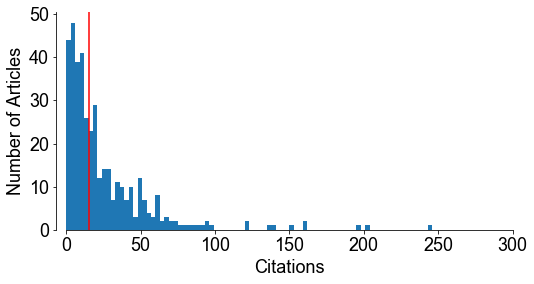

In [88]:
fig, ax1 = plt.subplots(figsize=(8,4))
cit = ax1.hist(dataset["Cited by"].dropna(),bins=100,range=[0,300])
ax1.axvline(dataset["Cited by"].median(),color="r")

ax1.set_xlabel("Citations")
ax1.set_ylabel("Number of Articles")
ax1.spines['left'].set_position(('outward', 10))
ax1.spines['bottom'].set_position(('outward', 0))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_xlim((0,300))
plt.show()

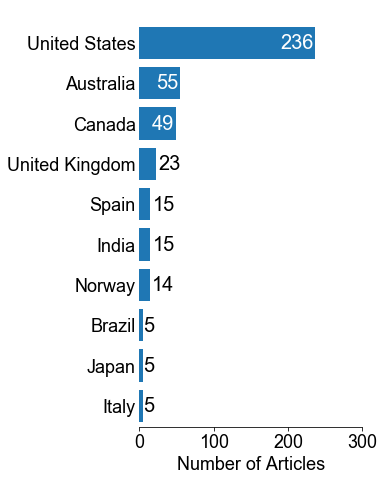

In [89]:


country = list()
for i,aff in enumerate(dataset["Affiliations"]):
    if type(aff)==str:
        affiliations = list()
        for a in aff.split(";"):
            temp = re.sub(r'[^\w\s]','',a.split(",")[-1] ).strip()
            if temp in ["Boston Mehrotra",'Hilo',"Mehrotra",'Comp S','Department of Electrical Engineering','California Qureshi','Massachusetts Busch','Busch','Univ Washington Image Comp Lib C','Texas Tech University','University of Wisconsin','Indiana Telehealth Advisory Consortium','Charleston','San Diego State University','RCCHR','Hutchings Psychiatric Center in Syracuse','is the telepsychology lead for the TeleLink Mental Health Program','The Hospital for Sick Children','Vanderbilt University','Giese','University of Washington','Amer Inst for Med and Biol Eng',"USA",'United States RCCHR','Simmons College','Vermillion','Washington']:
                temp="United States"
            elif temp in ['University of Athens']:
                temp="Greece"
            elif temp in ['Université du Québec en Outaouais','CRISE','The Royal Ottawa Health Care Group']:
                temp="Canada"
            elif temp in ['South Australian Mental Health Service','New South Wales']:
                temp="Australia"
            elif temp in ['CIBER de Fisiopatología de la Obesidad Y Nutrición CIBEROBU']:
                temp="Spain"
            elif temp in ['Seoul National University']:
                temp="South Korea"
            elif temp in ['Channel Islands']:
                temp="United Kingdom"
            elif temp in ['CRISE']:
                print(aff)
            affiliations.append(temp)
        affiliations = list(np.unique(affiliations))
    else:
        affiliations = np.nan
    country.append(affiliations)
dataset["countries"] = country

all_cs = list(filter(lambda x: type(x)!=float,country))

country_rnk = sorted(Counter([c for cs in all_cs for c in cs]).most_common(10),key=lambda x:x[1])

#plt.barh([x[0] for x in country_rnk],[x[1] for x in country_rnk])

fig, ax1 = plt.subplots(figsize=(4,8))

ax1.barh([x[0] for x in country_rnk],[x[1] for x in country_rnk])

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_position(('outward', -15))

ax1.tick_params(axis=u'y', which=u'both',length=0)
ax1.set_xlim((0,300))
ax1.set_xlabel("Number of Articles")

for i,n in enumerate([x[1] for x in country_rnk]):
    if n>=100:
        plt.text(x = n-46 , y = i-.15 , s = n , size = 20, color="white")
    elif n>=40:
        plt.text(x = n-32 , y = i-.15 , s = n , size = 20, color="white")
    elif n>=10:
        plt.text(x = n+3 , y = i-.15 , s = n , size = 20, color="black")
    else:
        plt.text(x = n , y = i-.15 , s = n , size = 20, color="black")

fig.savefig("countries_hist.tiff",dpi=300, bbox_inches = "tight")

In [90]:
from collections import defaultdict

countries = list(np.unique([c for cs in list(filter(lambda x: type(x)==list,country)) for c in cs]))
colab = defaultdict(list)
for cou in countries:
    for cs in dataset.countries:
        if type(cs)==list and cou in cs:
            colab[cou].extend(list(filter(lambda x: x!=cou,cs)))

            
colab = {it[0]:dict(Counter(it[1])) for it in list(colab.items())}

temp = defaultdict(list)
skip=list()
for c1 in colab:
    c1
    for c2 in colab[c1]:
        if c2 not in skip:
            #print(c1+";"+c2+";"+str(colab[c1][c2]))
            #temp.append((c1,c2,colab[c1][c2]))
            temp["from"].append(c1)
            temp["to"].append(c2)
            temp["value"].append(colab[c1][c2])
            skip.append(c1)

temp = pd.DataFrame(temp)
temp['from'] = temp['from'].apply(lambda x:x.title())
temp['to'] = temp['to'].apply(lambda x:x.title())


In [96]:
import holoviews as hv
from bokeh.models import HoverTool
import networkx as nx

#plt.subplots(figsize=(8,8))
MyHover1 = HoverTool(tooltips=None)

temp['col']='lightblue'
G=nx.from_pandas_edgelist(temp,'from', 'to', edge_attr=True)
graph = hv.Graph.from_networkx(G, nx.layout.kamada_kawai_layout)
labels = hv.Labels(graph.nodes, ['x', 'y'], 'index')

net = (graph.opts(tools=[MyHover1],
                  inspection_policy="nodes",
                  node_color='col',
                  node_line_color='col',
                  edge_line_width='value',
                  edge_color="lightgray") * labels.opts(text_font_size='12pt', text_color='black', bgcolor='white')).opts(width=600,height=800,xaxis=None,yaxis=None,toolbar=None)

hv.save(net,'country_net.png', backend='bokeh')
net

:Overlay
   .Graph.I  :Graph   [start,end]   (col,value)
   .Labels.I :Labels   [x,y]   (index)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
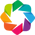

:Chord   [from,to]   (value,col)

In [97]:
import pandas as pd
import holoviews as hv
from holoviews import dim, opts
hv.extension('bokeh')


chord = hv.Chord(temp)
chord.opts( width=800, height=800)
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('to').str(),edge_line_width=5,
               labels='index', node_color=dim('index').str()))


chord.opts(label_text_font_size='12pt',toolbar=None)
hv.save(chord, 'country_chord.png')

chord

In [368]:
temp = dataset[['Source title','Cited by']].groupby('Source title').agg({"Source title":"count","Cited by":"mean"})
temp = temp.rename(columns= {"Source title":"n_articles"})
temp = temp.reset_index(drop=False).sort_values(by=["Cited by","n_articles"],ascending=False).dropna()

scatter = hv.Scatter(temp,kdims=["n_articles"],vdims=["Cited by","Source title"]).opts(tools=['hover'])
hv.save(scatter,"cit_n.html")
scatter

:Scatter   [n_articles]   (Cited by,Source title)